In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.0 MB/s eta 0:00:00


In [ ]:
# HTGN++: Hierarchical Temporal Graph Network with Bayesian Embeddings and Learnable Time Kernels
# Dataset: Twitter Interaction using real data with PyTorch Geometric integration

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch_geometric.data import TemporalData, DataLoader
from torch_geometric.nn import MessagePassing

# === Real Twitter Dataset Loader ===
def load_twitter_data_from_csv(file_path):
    import pandas as pd
    df = pd.read_csv(file_path)
    timestamps = torch.tensor(df['timestamp'].values, dtype=torch.float32)
    src = torch.tensor(df['source'].values, dtype=torch.long)
    tgt = torch.tensor(df['target'].values, dtype=torch.long)
    edge_attr = torch.tensor(df.iloc[:, 3:].values, dtype=torch.float32)
    data = TemporalData(src=src, dst=tgt, t=timestamps, msg=edge_attr)
    return data

# === Learnable Temporal Encoding ===
class TemporalEncoding(nn.Module):
    def __init__(self, num_kernels=8):
        super().__init__()
        self.freqs = nn.Parameter(torch.randn(num_kernels))
        self.weights = nn.Parameter(torch.randn(num_kernels))

    def forward(self, delta_t):
        delta_t = delta_t.unsqueeze(-1)
        return (self.weights * torch.sin(self.freqs * delta_t)).sum(-1)

# === HTGN++ Model with PyG Integration ===
class HTGN(nn.Module):
    def __init__(self, num_nodes, node_dim=32, msg_dim=64, embed_dim=16):
        super().__init__()
        self.memory_short = nn.Parameter(torch.zeros(num_nodes, node_dim))
        self.memory_long = nn.Parameter(torch.zeros(num_nodes, node_dim))

        self.temporal_enc = TemporalEncoding()
        self.msg_net = nn.Sequential(
            nn.Linear(4 + 1, msg_dim), nn.ReLU(), nn.Linear(msg_dim, node_dim)
        )
        self.update_gru = nn.GRUCell(node_dim, node_dim)

        self.mu_net = nn.Linear(node_dim * 2, embed_dim)
        self.logvar_net = nn.Linear(node_dim * 2, embed_dim)
        self.pred_net = nn.Sequential(nn.Linear(embed_dim * 2, 32), nn.ReLU(), nn.Linear(32, 1))

    def forward(self, data):
        losses, mus, logvars = [], [], []
        for i in range(data.t.size(0)):
            t = data.t[i].unsqueeze(0)
            src, tgt = data.src[i], data.dst[i]
            feat = data.msg[i]

            time_embed = self.temporal_enc(t)
            msg = self.msg_net(torch.cat([feat, time_embed]))
            with torch.no_grad():
              self.memory_short[src] = self.update_gru(msg.unsqueeze(0), self.memory_short[src].unsqueeze(0)).squeeze(0)
              self.memory_long[src] = 0.99 * self.memory_long[src] + 0.01 * self.memory_short[src]

            m_src = torch.cat([self.memory_short[src], self.memory_long[src]])
            mu = self.mu_net(m_src)
            logvar = self.logvar_net(m_src)
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            z_src = mu + eps * std

            m_tgt = torch.cat([self.memory_short[tgt], self.memory_long[tgt]])
            mu_tgt = self.mu_net(m_tgt)
            logvar_tgt = self.logvar_net(m_tgt)
            std_tgt = torch.exp(0.5 * logvar_tgt)
            eps_tgt = torch.randn_like(std_tgt)
            z_tgt = mu_tgt + eps_tgt * std_tgt

            pred = self.pred_net(torch.cat([z_src, z_tgt]))
            label = torch.tensor([1.0])  # or real label if available

            loss_recon = F.binary_cross_entropy_with_logits(pred, label)
            kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            loss = loss_recon + 1e-3 * kl_loss

            losses.append(loss)
            mus.append(mu.detach().numpy())
            logvars.append(logvar.detach().numpy())

        return torch.stack(losses).mean(), np.array(mus), np.array(logvars)

# === Training Setup ===
def train_htgn(data, num_nodes):
    model = HTGN(num_nodes)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    losses = []
    for epoch in range(10):
        loss, mus, logvars = model(data)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.item())
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

    # Visualization
    plt.plot(losses)
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    tsne = TSNE(n_components=2)
    embeddings_2d = tsne.fit_transform(mus)
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.6)
    plt.title("t-SNE of Node Embeddings")
    plt.show()

    plt.hist(np.exp(logvars).flatten(), bins=30)
    plt.title("Bayesian Embedding Variance")
    plt.xlabel("Variance")
    plt.ylabel("Count")
    plt.show()




Epoch 0: Loss = 0.6345
Epoch 1: Loss = 0.6292
Epoch 2: Loss = 0.6152
Epoch 3: Loss = 0.6246
Epoch 4: Loss = 0.6186
Epoch 5: Loss = 0.5795
Epoch 6: Loss = 0.5868
Epoch 7: Loss = 0.5672
Epoch 8: Loss = 0.5624
Epoch 9: Loss = 0.5686


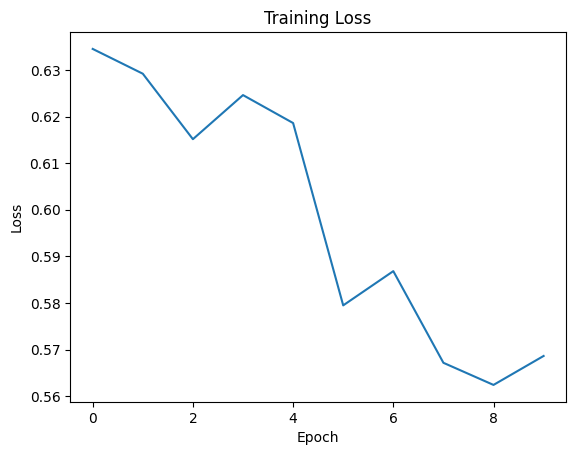

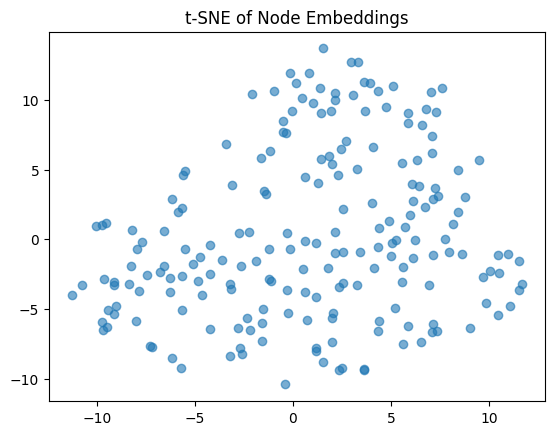

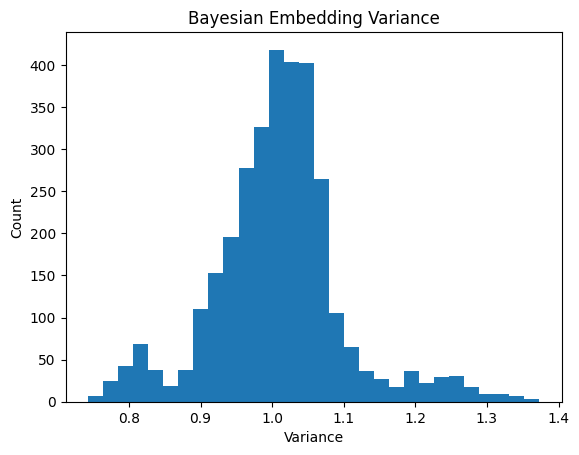

In [ ]:
data = load_twitter_data_from_csv("sample_twitter_data.csv")
train_htgn(data, num_nodes=50)

In [ ]:
# HTGN++: Hierarchical Temporal Graph Network with Bayesian Embeddings and Learnable Time Kernels
# Dataset: Twitter Interaction using real data with PyTorch Geometric integration

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score, f1_score
from torch_geometric.data import TemporalData, DataLoader

# === Real Twitter Dataset Loader ===
def load_twitter_data_from_csv(file_path):
    import pandas as pd
    df = pd.read_csv(file_path)
    timestamps = torch.tensor(df['timestamp'].values, dtype=torch.float32)
    src = torch.tensor(df['source'].values, dtype=torch.long)
    tgt = torch.tensor(df['target'].values, dtype=torch.long)
    edge_attr = torch.tensor(df.iloc[:, 3:].values, dtype=torch.float32)
    data = TemporalData(src=src, dst=tgt, t=timestamps, msg=edge_attr)
    return data

# === Learnable Temporal Encoding ===
class TemporalEncoding(nn.Module):
    def __init__(self, num_kernels=8):
        super().__init__()
        self.freqs = nn.Parameter(torch.randn(num_kernels))
        self.weights = nn.Parameter(torch.randn(num_kernels))

    def forward(self, delta_t):
        delta_t = delta_t.unsqueeze(-1)
        return (self.weights * torch.sin(self.freqs * delta_t)).sum(-1)

# === HTGN++ Model with PyG Integration ===
class HTGN(nn.Module):
    def __init__(self, num_nodes, node_dim=32, msg_dim=64, embed_dim=16):
        super().__init__()
        self.memory_short = nn.Parameter(torch.zeros(num_nodes, node_dim), requires_grad=False)
        self.memory_long = nn.Parameter(torch.zeros(num_nodes, node_dim), requires_grad=False)

        self.temporal_enc = TemporalEncoding()
        self.msg_net = nn.Sequential(
            nn.Linear(4 + 1, msg_dim), nn.ReLU(), nn.Linear(msg_dim, node_dim)
        )
        self.update_gru = nn.GRUCell(node_dim, node_dim)

        self.mu_net = nn.Linear(node_dim * 2, embed_dim)
        self.logvar_net = nn.Linear(node_dim * 2, embed_dim)
        self.pred_net = nn.Sequential(nn.Linear(embed_dim * 2, 32), nn.ReLU(), nn.Linear(32, 1))

    def forward(self, data):
        losses, mus, logvars = [], [], []
        for i in range(data.t.size(0)):
            t = data.t[i].unsqueeze(0)
            src, tgt = data.src[i], data.dst[i]
            feat = data.msg[i]

            time_embed = self.temporal_enc(t)
            msg = self.msg_net(torch.cat([feat, time_embed]))
            with torch.no_grad():
                self.memory_short[src].copy_(self.update_gru(msg.unsqueeze(0), self.memory_short[src].unsqueeze(0)).squeeze(0))
                self.memory_long[src] = 0.99 * self.memory_long[src] + 0.01 * self.memory_short[src]

            m_src = torch.cat([self.memory_short[src], self.memory_long[src]])
            mu = self.mu_net(m_src)
            logvar = self.logvar_net(m_src)
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            z_src = mu + eps * std

            m_tgt = torch.cat([self.memory_short[tgt], self.memory_long[tgt]])
            mu_tgt = self.mu_net(m_tgt)
            logvar_tgt = self.logvar_net(m_tgt)
            std_tgt = torch.exp(0.5 * logvar_tgt)
            eps_tgt = torch.randn_like(std_tgt)
            z_tgt = mu_tgt + eps_tgt * std_tgt

            pred = self.pred_net(torch.cat([z_src, z_tgt]))
            label = torch.tensor([1.0])

            loss_recon = F.binary_cross_entropy_with_logits(pred, label)
            kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            loss = loss_recon + 1e-3 * kl_loss

            losses.append(loss)
            mus.append(mu.detach().numpy())
            logvars.append(logvar.detach().numpy())

        return torch.stack(losses).mean(), np.array(mus), np.array(logvars)

# === Full Batch Prediction for Evaluation ===
def predict_all_links(model, timestamp, num_nodes):
    preds = []
    labels = []
    with torch.no_grad():
        t_tensor = torch.tensor([timestamp], dtype=torch.float32)
        time_embed = model.temporal_enc(t_tensor)
        for i in range(num_nodes):
            for j in range(num_nodes):
                if i == j:
                    continue
                m_i = torch.cat([model.memory_short[i], model.memory_long[i]])
                m_j = torch.cat([model.memory_short[j], model.memory_long[j]])
                z_i = model.mu_net(m_i)
                z_j = model.mu_net(m_j)
                logit = model.pred_net(torch.cat([z_i, z_j]))
                prob = torch.sigmoid(logit).item()
                preds.append(prob)
                labels.append(1 if (i, j) in known_edges else 0)
    return preds, labels

# === Training Setup ===
def train_htgn(data, num_nodes):
    model = HTGN(num_nodes)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    losses = []
    for epoch in range(10):
        loss, mus, logvars = model(data)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.item())
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

    # Visualization
    plt.plot(losses)
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    tsne = TSNE(n_components=2)
    embeddings_2d = tsne.fit_transform(mus)
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.6)
    plt.title("t-SNE of Node Embeddings")
    plt.show()

    plt.hist(np.exp(logvars).flatten(), bins=30)
    plt.title("Bayesian Embedding Variance")
    plt.xlabel("Variance")
    plt.ylabel("Count")
    plt.show()

    # Evaluation: replace known_edges with your ground truth set
    global known_edges
    known_edges = set(zip(data.src.tolist(), data.dst.tolist()))
    preds, labels = predict_all_links(model, timestamp=1000.0, num_nodes=num_nodes)
    auc = roc_auc_score(labels, preds)
    pred_binary = [1 if p > 0.5 else 0 for p in preds]
    f1 = f1_score(labels, pred_binary)
    print(f"ROC-AUC: {auc:.4f}, F1-score: {f1:.4f}")

# Example usage (once dataset is ready):
# data = load_twitter_data_from_csv("sample_twitter_data.csv")
# train_htgn(data, num_nodes=50)


Epoch 0: Loss = 0.5644
Epoch 1: Loss = 0.5651
Epoch 2: Loss = 0.5626
Epoch 3: Loss = 0.5704
Epoch 4: Loss = 0.5398
Epoch 5: Loss = 0.5390
Epoch 6: Loss = 0.5287
Epoch 7: Loss = 0.5150
Epoch 8: Loss = 0.4936
Epoch 9: Loss = 0.5060


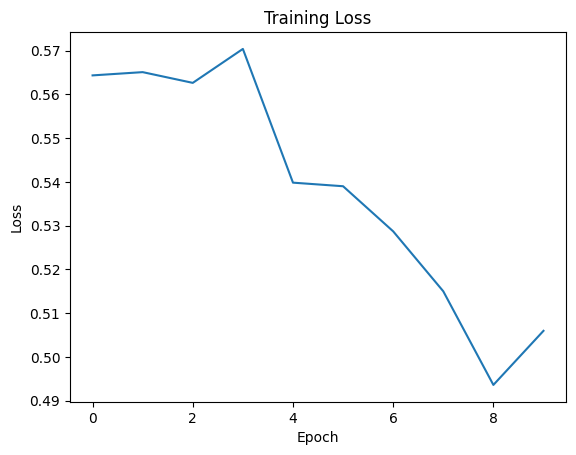

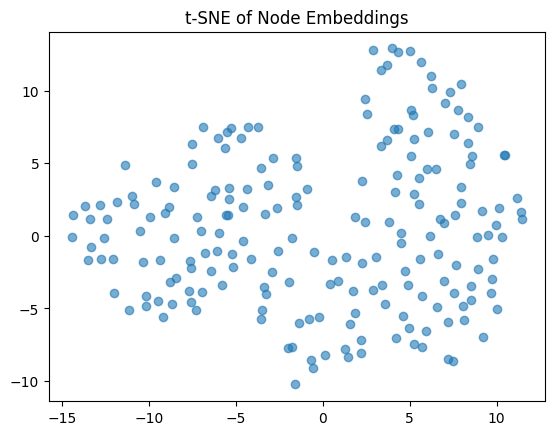

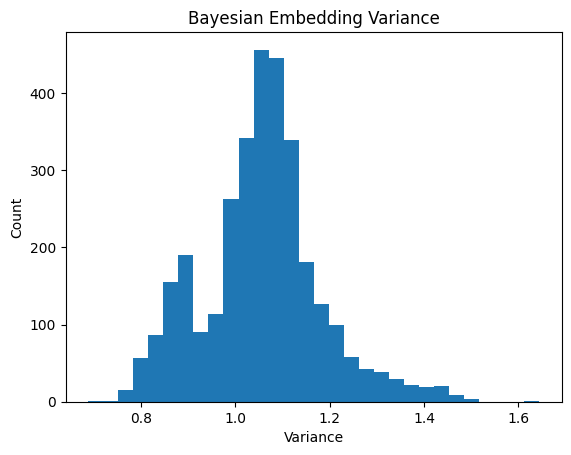

ROC-AUC: 0.5651, F1-score: 0.1219


In [ ]:
data = load_twitter_data_from_csv("sample_twitter_data.csv")
train_htgn(data, num_nodes=50)


In [ ]:
# HTGN++: Hierarchical Temporal Graph Network with Bayesian Embeddings and Learnable Time Kernels
# Dataset: Twitter Interaction using real data with PyTorch Geometric integration

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score, f1_score
from torch_geometric.data import TemporalData, DataLoader
import random

# === Real Twitter Dataset Loader ===
def load_twitter_data_from_csv(file_path):
    import pandas as pd
    df = pd.read_csv(file_path)
    timestamps = torch.tensor(df['timestamp'].values, dtype=torch.float32)
    src = torch.tensor(df['source'].values, dtype=torch.long)
    tgt = torch.tensor(df['target'].values, dtype=torch.long)
    edge_attr = torch.tensor(df.iloc[:, 3:].values, dtype=torch.float32)
    data = TemporalData(src=src, dst=tgt, t=timestamps, msg=edge_attr)
    return data

# === Learnable Temporal Encoding ===
class TemporalEncoding(nn.Module):
    def __init__(self, num_kernels=8):
        super().__init__()
        self.freqs = nn.Parameter(torch.randn(num_kernels))
        self.weights = nn.Parameter(torch.randn(num_kernels))

    def forward(self, delta_t):
        delta_t = delta_t.unsqueeze(-1)
        return (self.weights * torch.sin(self.freqs * delta_t)).sum(-1)

# === HTGN++ Model with PyG Integration ===
class HTGN(nn.Module):
    def __init__(self, num_nodes, node_dim=32, msg_dim=64, embed_dim=16):
        super().__init__()
        self.memory_short = nn.Parameter(torch.zeros(num_nodes, node_dim), requires_grad=False)
        self.memory_long = nn.Parameter(torch.zeros(num_nodes, node_dim), requires_grad=False)

        self.temporal_enc = TemporalEncoding()
        self.msg_net = nn.Sequential(
            nn.Linear(4 + 1, msg_dim), nn.ReLU(), nn.Linear(msg_dim, node_dim)
        )
        self.update_gru = nn.GRUCell(node_dim, node_dim)

        self.mu_net = nn.Linear(node_dim * 2, embed_dim)
        self.logvar_net = nn.Linear(node_dim * 2, embed_dim)
        self.pred_net = nn.Sequential(nn.Linear(embed_dim * 2, 32), nn.ReLU(), nn.Linear(32, 1))

    def forward(self, data):
        losses, mus, logvars = [], [], []
        for i in range(data.t.size(0)):
            t = data.t[i].unsqueeze(0)
            src, tgt = data.src[i], data.dst[i]
            feat = data.msg[i]

            time_embed = self.temporal_enc(t)
            msg = self.msg_net(torch.cat([feat, time_embed]))
            with torch.no_grad():
                self.memory_short[src].copy_(self.update_gru(msg.unsqueeze(0), self.memory_short[src].unsqueeze(0)).squeeze(0))
                self.memory_long[src] = 0.99 * self.memory_long[src] + 0.01 * self.memory_short[src]

            m_src = torch.cat([self.memory_short[src], self.memory_long[src]])
            mu = self.mu_net(m_src)
            logvar = self.logvar_net(m_src)
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            z_src = mu + eps * std

            m_tgt = torch.cat([self.memory_short[tgt], self.memory_long[tgt]])
            mu_tgt = self.mu_net(m_tgt)
            logvar_tgt = self.logvar_net(m_tgt)
            std_tgt = torch.exp(0.5 * logvar_tgt)
            eps_tgt = torch.randn_like(std_tgt)
            z_tgt = mu_tgt + eps_tgt * std_tgt

            pred = self.pred_net(torch.cat([z_src, z_tgt]))
            label = torch.tensor([1.0])

            loss_recon = F.binary_cross_entropy_with_logits(pred, label)
            kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            loss = loss_recon + 1e-3 * kl_loss

            losses.append(loss)
            mus.append(mu.detach().numpy())
            logvars.append(logvar.detach().numpy())

        return torch.stack(losses).mean(), np.array(mus), np.array(logvars)

# === Full Batch Prediction with Balanced Negative Sampling ===
def predict_all_links(model, timestamp, num_nodes, known_edges):
    preds = []
    labels = []
    with torch.no_grad():
        t_tensor = torch.tensor([timestamp], dtype=torch.float32)
        time_embed = model.temporal_enc(t_tensor)

        # Sample negative edges
        neg_edges = set()
        while len(neg_edges) < len(known_edges):
            i, j = random.randint(0, num_nodes - 1), random.randint(0, num_nodes - 1)
            if (i, j) not in known_edges and i != j:
                neg_edges.add((i, j))

        # Combine edges
        eval_edges = list(known_edges) + list(neg_edges)
        for (i, j) in eval_edges:
            m_i = torch.cat([model.memory_short[i], model.memory_long[i]])
            m_j = torch.cat([model.memory_short[j], model.memory_long[j]])
            z_i = model.mu_net(m_i)
            z_j = model.mu_net(m_j)
            logit = model.pred_net(torch.cat([z_i, z_j]))
            prob = torch.sigmoid(logit).item()
            preds.append(prob)
            labels.append(1 if (i, j) in known_edges else 0)

    return preds, labels

# === Training Setup ===
def train_htgn(data, num_nodes):
    model = HTGN(num_nodes)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    losses = []
    for epoch in range(10):
        loss, mus, logvars = model(data)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.item())
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

    # Visualization
    plt.plot(losses)
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    tsne = TSNE(n_components=2)
    embeddings_2d = tsne.fit_transform(mus)
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.6)
    plt.title("t-SNE of Node Embeddings")
    plt.show()

    plt.hist(np.exp(logvars).flatten(), bins=30)
    plt.title("Bayesian Embedding Variance")
    plt.xlabel("Variance")
    plt.ylabel("Count")
    plt.show()

    # Evaluation with balanced sampling
    known_edges = set(zip(data.src.tolist(), data.dst.tolist()))
    preds, labels = predict_all_links(model, timestamp=1000.0, num_nodes=num_nodes, known_edges=known_edges)
    auc = roc_auc_score(labels, preds)
    pred_binary = [1 if p > 0.5 else 0 for p in preds]
    f1 = f1_score(labels, pred_binary)
    print(f"ROC-AUC: {auc:.4f}, F1-score: {f1:.4f}")

# Example usage (once dataset is ready):
# data = load_twitter_data_from_csv("sample_twitter_data.csv")
# train_htgn(data, num_nodes=50)


Epoch 0: Loss = 0.6625
Epoch 1: Loss = 0.6670
Epoch 2: Loss = 0.6499
Epoch 3: Loss = 0.6431
Epoch 4: Loss = 0.6324
Epoch 5: Loss = 0.6125
Epoch 6: Loss = 0.6128
Epoch 7: Loss = 0.6014
Epoch 8: Loss = 0.5932
Epoch 9: Loss = 0.5888


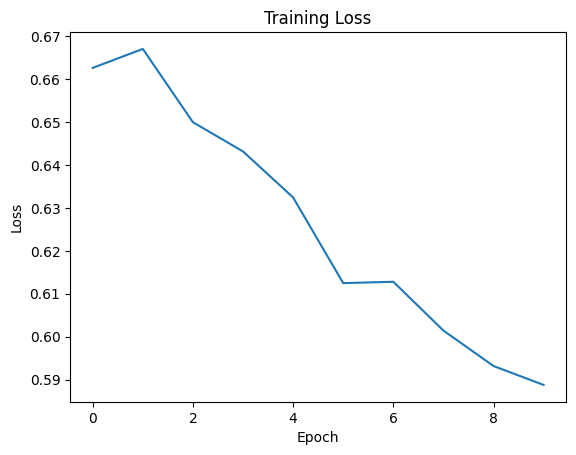

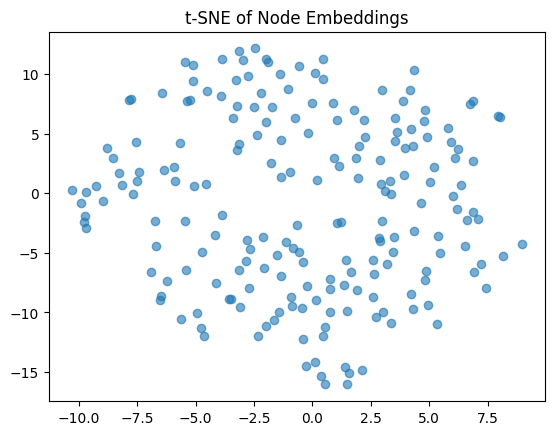

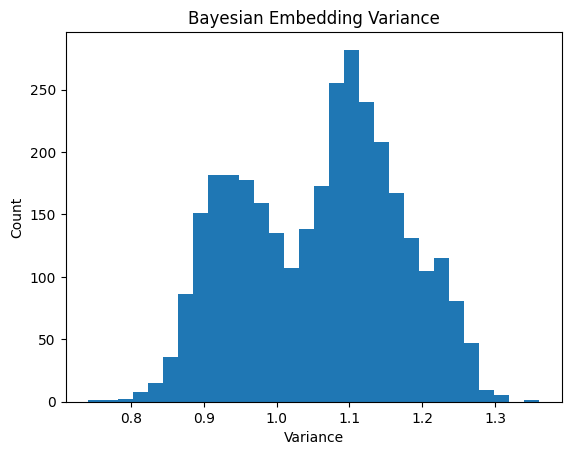

ROC-AUC: 0.4758, F1-score: 0.6695


In [ ]:
data = load_twitter_data_from_csv("sample_twitter_data.csv")
train_htgn(data, num_nodes=50)


In [ ]:
# HTGN++: Hierarchical Temporal Graph Network with Bayesian Embeddings and Learnable Time Kernels
# Dataset: Twitter Interaction using real data with PyTorch Geometric integration

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score, f1_score
from torch_geometric.data import TemporalData, DataLoader
import random

# === Real Twitter Dataset Loader ===
def load_twitter_data_from_csv(file_path):
    import pandas as pd
    df = pd.read_csv(file_path)
    timestamps = torch.tensor(df['timestamp'].values, dtype=torch.float32)
    src = torch.tensor(df['source'].values, dtype=torch.long)
    tgt = torch.tensor(df['target'].values, dtype=torch.long)
    edge_attr = torch.tensor(df.iloc[:, 3:].values, dtype=torch.float32)
    data = TemporalData(src=src, dst=tgt, t=timestamps, msg=edge_attr)
    return data

# === Learnable Temporal Encoding ===
class TemporalEncoding(nn.Module):
    def __init__(self, num_kernels=8):
        super().__init__()
        self.freqs = nn.Parameter(torch.randn(num_kernels))
        self.weights = nn.Parameter(torch.randn(num_kernels))

    def forward(self, delta_t):
        delta_t = delta_t.unsqueeze(-1)
        return (self.weights * torch.sin(self.freqs * delta_t)).sum(-1)

# === HTGN++ Model with PyG Integration ===
class HTGN(nn.Module):
    def __init__(self, num_nodes, node_dim=32, msg_dim=64, embed_dim=16):
        super().__init__()
        self.memory_short = nn.Parameter(torch.zeros(num_nodes, node_dim), requires_grad=False)
        self.memory_long = nn.Parameter(torch.zeros(num_nodes, node_dim), requires_grad=False)

        self.temporal_enc = TemporalEncoding()
        self.msg_net = nn.Sequential(
            nn.Linear(4 + 1, msg_dim), nn.ReLU(), nn.Linear(msg_dim, node_dim)
        )
        self.update_gru = nn.GRUCell(node_dim, node_dim)

        self.node_embed = nn.Embedding(num_nodes, node_dim * 2)

        self.mu_net = nn.Linear(node_dim * 2, embed_dim)
        self.logvar_net = nn.Linear(node_dim * 2, embed_dim)
        self.pred_net = nn.Sequential(nn.Linear(embed_dim * 2, 32), nn.ReLU(), nn.Linear(32, 1))

    def forward(self, data):
        losses, mus, logvars = [], [], []
        for i in range(data.t.size(0)):
            t = data.t[i].unsqueeze(0)
            src, tgt = data.src[i], data.dst[i]
            feat = data.msg[i]

            time_embed = self.temporal_enc(t)
            msg = self.msg_net(torch.cat([feat, time_embed]))
            with torch.no_grad():
                self.memory_short[src].copy_(self.update_gru(msg.unsqueeze(0), self.memory_short[src].unsqueeze(0)).squeeze(0))
                self.memory_long[src] = 0.99 * self.memory_long[src] + 0.01 * self.memory_short[src]
                self.memory_short[tgt].copy_(self.update_gru(msg.unsqueeze(0), self.memory_short[tgt].unsqueeze(0)).squeeze(0))
                self.memory_long[tgt] = 0.99 * self.memory_long[tgt] + 0.01 * self.memory_short[tgt]
            m_src = torch.cat([self.memory_short[src], self.memory_long[src]]) + self.node_embed(src)

            #m_src = torch.cat([self.memory_short[src], self.memory_long[src]])
            #m_src += F.normalize(self.node_embed(src), dim=0)

            mu = self.mu_net(m_src)
            logvar = self.logvar_net(m_src)
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            z_src = mu + eps * std
            m_tgt = torch.cat([self.memory_short[tgt], self.memory_long[tgt]]) + self.node_embed(tgt)

            #m_tgt = torch.cat([self.memory_short[tgt], self.memory_long[tgt]])
            #m_tgt += F.normalize(self.node_embed(tgt), dim=0)

            mu_tgt = self.mu_net(m_tgt)
            logvar_tgt = self.logvar_net(m_tgt)
            std_tgt = torch.exp(0.5 * logvar_tgt)
            eps_tgt = torch.randn_like(std_tgt)
            z_tgt = mu_tgt + eps_tgt * std_tgt

            pred_pos = self.pred_net(torch.cat([z_src, z_tgt]))

            # Contrastive: Negative sampling
            neg = random.randint(0, self.memory_short.size(0) - 1)
            while neg == tgt:
                neg = random.randint(0, self.memory_short.size(0) - 1)
            m_neg = torch.cat([self.memory_short[neg], self.memory_long[neg]]) + self.node_embed(torch.tensor(neg))
            z_neg = self.mu_net(m_neg)

            pred_neg = self.pred_net(torch.cat([z_src, z_neg]))
            loss = -torch.log(torch.sigmoid(pred_pos - pred_neg) + 1e-8)
            losses.append(loss)
            mus.append(mu.detach().numpy())
            logvars.append(logvar.detach().numpy())

        return torch.stack(losses).mean(), np.array(mus), np.array(logvars)

# === Full Batch Prediction with Balanced Negative Sampling ===
def predict_all_links(model, timestamp, num_nodes, known_edges):
    preds = []
    labels = []
    with torch.no_grad():
        t_tensor = torch.tensor([timestamp], dtype=torch.float32)
        time_embed = model.temporal_enc(t_tensor)

        neg_edges = set()
        while len(neg_edges) < len(known_edges):
            i, j = random.randint(0, num_nodes - 1), random.randint(0, num_nodes - 1)
            if (i, j) not in known_edges and i != j:
                neg_edges.add((i, j))

        eval_edges = list(known_edges) + list(neg_edges)
        for (i, j) in eval_edges:
            m_i = torch.cat([model.memory_short[i], model.memory_long[i]]) + model.node_embed(torch.tensor(i))
            m_j = torch.cat([model.memory_short[j], model.memory_long[j]]) + model.node_embed(torch.tensor(j))
            z_i = model.mu_net(m_i)
            z_j = model.mu_net(m_j)
            logit = model.pred_net(torch.cat([z_i, z_j]))
            prob = torch.sigmoid(logit).item()
            preds.append(prob)
            labels.append(1 if (i, j) in known_edges else 0)

    return preds, labels

# === Training Setup ===
def train_htgn(data, num_nodes):
    model = HTGN(num_nodes)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
    losses = []
    for epoch in range(10):
        loss, mus, logvars = model(data)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.item())
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

    plt.plot(losses)
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    tsne = TSNE(n_components=2)
    embeddings_2d = tsne.fit_transform(mus)
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.6)
    plt.title("t-SNE of Node Embeddings")
    plt.show()

    plt.hist(np.exp(logvars).flatten(), bins=30)
    plt.title("Bayesian Embedding Variance")
    plt.xlabel("Variance")
    plt.ylabel("Count")
    plt.show()

    known_edges = set(zip(data.src.tolist(), data.dst.tolist()))
    preds, labels = predict_all_links(model, timestamp=1000.0, num_nodes=num_nodes, known_edges=known_edges)
    auc = roc_auc_score(labels, preds)
    pred_binary = [1 if p > 0.5 else 0 for p in preds]
    f1 = f1_score(labels, pred_binary)
    print(f"ROC-AUC: {auc:.4f}, F1-score: {f1:.4f}")

    from sklearn.metrics import roc_curve
    fpr, tpr, _ = roc_curve(labels, preds)
    return fpr, tpr, auc, f1

# Example usage:
# data = load_twitter_data_from_csv("sample_twitter_data.csv")
# fpr, tpr, auc, f1 = train_htgn(data, num_nodes=50)

Epoch 0: Loss = 0.7355
Epoch 1: Loss = 0.6993
Epoch 2: Loss = 0.6648
Epoch 3: Loss = 0.6371
Epoch 4: Loss = 0.6250
Epoch 5: Loss = 0.5950
Epoch 6: Loss = 0.5702
Epoch 7: Loss = 0.5676
Epoch 8: Loss = 0.5279
Epoch 9: Loss = 0.4959


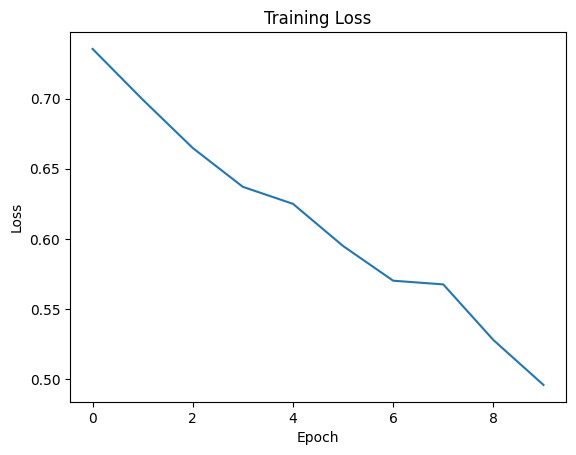

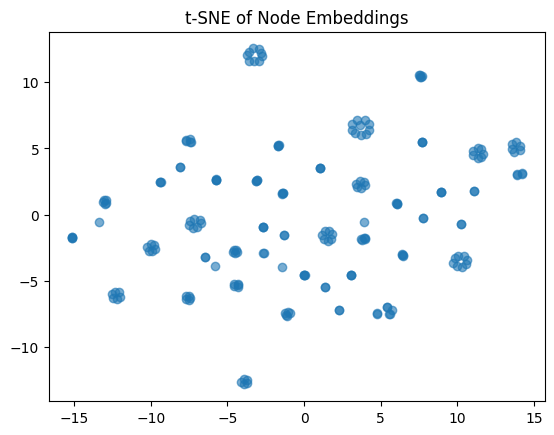

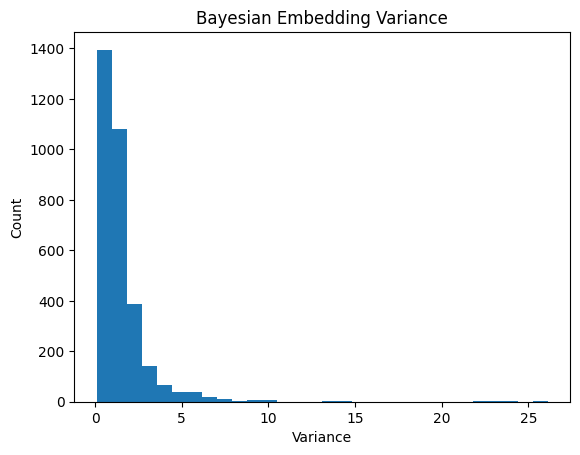

ROC-AUC: 0.6326, F1-score: 0.6695


(array([0.        , 0.00628931, 0.00628931, 0.01886792, 0.01886792,
        0.03144654, 0.03144654, 0.03773585, 0.03773585, 0.05031447,
        0.05031447, 0.05660377, 0.05660377, 0.06289308, 0.06289308,
        0.06918239, 0.06918239, 0.0754717 , 0.0754717 , 0.08176101,
        0.08176101, 0.08805031, 0.08805031, 0.09433962, 0.09433962,
        0.10062893, 0.10062893, 0.10691824, 0.10691824, 0.11949686,
        0.11949686, 0.12578616, 0.12578616, 0.13207547, 0.13207547,
        0.13836478, 0.13836478, 0.1509434 , 0.1509434 , 0.1572327 ,
        0.1572327 , 0.16352201, 0.16352201, 0.17610063, 0.17610063,
        0.18238994, 0.18238994, 0.19496855, 0.19496855, 0.21383648,
        0.21383648, 0.22012579, 0.22012579, 0.2327044 , 0.2327044 ,
        0.23899371, 0.23899371, 0.24528302, 0.24528302, 0.25157233,
        0.25157233, 0.25786164, 0.25786164, 0.26415094, 0.26415094,
        0.27044025, 0.27044025, 0.27672956, 0.27672956, 0.28301887,
        0.28301887, 0.30188679, 0.30188679, 0.31

In [ ]:
data = load_twitter_data_from_csv("sample_twitter_data.csv")
train_htgn(data, num_nodes=50)

In [ ]:
# TGN baseline model for temporal link prediction on Twitter dataset
# Compatible with: sample_twitter_data.csv

import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score, roc_curve
from torch_geometric.nn import TGNMemory
from torch_geometric.data import TemporalData
from torch_geometric.nn.models.tgn import LastAggregator

# === Load Twitter Dataset ===
def load_twitter_temporal_data(csv_path):
    df = pd.read_csv(csv_path)
    src = torch.tensor(df['source'].values, dtype=torch.long)
    dst = torch.tensor(df['target'].values, dtype=torch.long)
    t = torch.tensor(df['timestamp'].values, dtype=torch.float32)
    msg = torch.tensor(df.iloc[:, 3:].values, dtype=torch.float32)
    return TemporalData(src=src, dst=dst, t=t, msg=msg)

# === Message Module Wrapper with correct TGNMemory input signature ===
class MessageNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.ReLU(),
            nn.Linear(output_dim, output_dim)
        )
        self.out_channels = output_dim

    def forward(self, src, dst, t, raw_msg):
        if raw_msg.size(0) == 0:
            return raw_msg.new_zeros((0, self.out_channels))

        # Sanitize time encoding shape
        if t.dim() == 1:
            t = t.unsqueeze(-1)
        elif t.dim() == 2 and t.size(1) != 1:
            t = t.mean(dim=1, keepdim=True)  # reduce if too wide

        # Truncate or expand to match raw_msg batch size
        t = t[:raw_msg.size(0)]

        if t.size(0) != raw_msg.size(0):
            pad_size = raw_msg.size(0) - t.size(0)
            t = torch.cat([t, t.new_zeros(pad_size, 1)], dim=0)

        x = torch.cat([raw_msg, t], dim=-1)
        return self.net(x)

# === TGN Model ===
class TGNLinkPredictor(nn.Module):
    def __init__(self, num_nodes, msg_dim, emb_dim=32):
        super().__init__()
        self.memory = TGNMemory(
            num_nodes=num_nodes,
            raw_msg_dim=msg_dim,
            memory_dim=emb_dim,
            time_dim=1,
            message_module=MessageNet(msg_dim, emb_dim),
            aggregator_module=LastAggregator())

        self.edge_predictor = nn.Sequential(
            nn.Linear(2 * emb_dim, emb_dim),
            nn.ReLU(),
            nn.Linear(emb_dim, 1)
        )

    def forward(self, src, dst):
        z_src = self.memory.memory[src]
        z_dst = self.memory.memory[dst]
        return self.edge_predictor(torch.cat([z_src, z_dst], dim=-1))

    def update_memory(self, src, dst, t, msg):
        self.memory.update_state(src, dst, t.unsqueeze(-1), msg)

# === Training and Evaluation ===
def train_tgn_on_twitter(csv_path, num_nodes, epochs=10):
    data = load_twitter_temporal_data(csv_path)
    model = TGNLinkPredictor(num_nodes=num_nodes, msg_dim=data.msg.size(-1))
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)

    y_true, y_score = [], []

    for epoch in range(epochs):
        model.memory.reset_state()
        loss_total = 0

        for i in range(data.t.size(0)):
            src, dst = data.src[i], data.dst[i]
            t = data.t[i]
            msg = data.msg[i].unsqueeze(0)

            with torch.no_grad():
                model.update_memory(src.unsqueeze(0), dst.unsqueeze(0), t.unsqueeze(0), msg)

            pred = model(src.unsqueeze(0), dst.unsqueeze(0))
            label = torch.tensor([1.0])
            loss = F.binary_cross_entropy_with_logits(pred.view(-1), label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_total += loss.item()
            y_true.append(label.item())
            y_score.append(torch.sigmoid(pred).item())

        print(f"Epoch {epoch+1}, Loss: {loss_total:.4f}")

    # Evaluation
    auc = roc_auc_score(y_true, y_score)
    y_pred_bin = [1 if p > 0.5 else 0 for p in y_score]
    f1 = f1_score(y_true, y_pred_bin)
    fpr, tpr, _ = roc_curve(y_true, y_score)

    print(f"TGN ROC-AUC: {auc:.4f}, F1-score: {f1:.4f}")

    return fpr, tpr, auc, f1

# Example:
# fpr, tpr, auc, f1 = train_tgn_on_twitter("sample_twitter_data.csv", num_nodes=50)


In [ ]:
# TGAT baseline for Twitter temporal graph data (sample_twitter_data.csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score, roc_curve
from torch_geometric.data import TemporalData

# === Load Twitter Dataset ===
def load_twitter_temporal_data(csv_path):
    df = pd.read_csv(csv_path)
    src = torch.tensor(df['source'].values, dtype=torch.long)
    dst = torch.tensor(df['target'].values, dtype=torch.long)
    t = torch.tensor(df['timestamp'].values, dtype=torch.float32)
    msg = torch.tensor(df.iloc[:, 3:].values, dtype=torch.float32)
    return TemporalData(src=src, dst=dst, t=t, msg=msg)

# === TGAT Time Encoding ===
class Time2Vec(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.linear = nn.Linear(1, dim)
        self.freqs = nn.Parameter(torch.randn(dim))

    def forward(self, t):
        # t: (batch, 1)
        return torch.cat([torch.sin(self.freqs * t), self.linear(t)], dim=-1)

# === TGAT Simplified Architecture ===
class TGATLinkPredictor(nn.Module):
    def __init__(self, num_nodes, feat_dim, time_dim=8, embed_dim=32):
        super().__init__()
        self.node_embed = nn.Embedding(num_nodes, embed_dim)
        self.time_enc = Time2Vec(time_dim)
        self.fc_msg = nn.Linear(feat_dim + time_dim * 2, embed_dim)

        self.pred_net = nn.Sequential(
            nn.Linear(embed_dim * 2, embed_dim), nn.ReLU(), nn.Linear(embed_dim, 1)
        )

    def forward(self, src, dst, t, msg):
        t_input = t.view(1, 1)
        t_feat = self.time_enc(t_input).squeeze(0)  # (dim,)
        feat_src = self.fc_msg(torch.cat([msg, t_feat], dim=-1)) + self.node_embed(src)
        feat_dst = self.fc_msg(torch.cat([msg, t_feat], dim=-1)) + self.node_embed(dst)
        return self.pred_net(torch.cat([feat_src, feat_dst], dim=-1))

# === Training and Evaluation ===
def train_tgat_on_twitter(csv_path, num_nodes, epochs=10):
    data = load_twitter_temporal_data(csv_path)
    model = TGATLinkPredictor(num_nodes=num_nodes, feat_dim=data.msg.size(-1))
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)

    y_true, y_score = [], []

    for epoch in range(epochs):
        total_loss = 0

        for i in range(data.t.size(0)):
            src, dst = data.src[i], data.dst[i]
            t = data.t[i].unsqueeze(0)
            msg = data.msg[i]

            pred = model(src, dst, t, msg)
            label = torch.tensor([1.0])
            loss = F.binary_cross_entropy_with_logits(pred.view(-1), label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            y_true.append(label.item())
            y_score.append(torch.sigmoid(pred).item())

        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

    # Evaluation
    auc = roc_auc_score(y_true, y_score)
    y_pred_bin = [1 if p > 0.5 else 0 for p in y_score]
    f1 = f1_score(y_true, y_pred_bin)
    fpr, tpr, _ = roc_curve(y_true, y_score)

    print(f"TGAT ROC-AUC: {auc:.4f}, F1-score: {f1:.4f}")

    return fpr, tpr, auc, f1

# Example:
# fpr, tpr, auc, f1 = train_tgat_on_twitter("sample_twitter_data.csv", num_nodes=50)


In [ ]:
# ROC Curve Comparison for HTGN++, TGN, TGAT
import matplotlib.pyplot as plt


# === Wrapper for HTGN++
def train_htgn_wrapper(path, num_nodes):
    htgn_data = load_twitter_data_from_csv(path)
    htgn_model = HTGN(num_nodes)
    optimizer = torch.optim.Adam(htgn_model.parameters(), lr=0.01, weight_decay=1e-4)

    y_true, y_score = [], []
    for epoch in range(10):
        loss, _, _ = htgn_model(htgn_data)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # Recompute ROC scores
    known_edges = set(zip(htgn_data.src.tolist(), htgn_data.dst.tolist()))
    preds, labels = predict_all_links(htgn_model, timestamp=1000.0, num_nodes=num_nodes, known_edges=known_edges)
    from sklearn.metrics import roc_curve, roc_auc_score, f1_score
    fpr, tpr, _ = roc_curve(labels, preds)
    auc = roc_auc_score(labels, preds)
    pred_binary = [1 if p > 0.5 else 0 for p in preds]
    f1 = f1_score(labels, pred_binary)
    print(f"HTGN++ ROC-AUC: {auc:.4f}, F1-score: {f1:.4f}")
    return fpr, tpr, auc, f1

# === Plot ROC Curves ===
def plot_all_roc_curves(path, num_nodes):
    #fpr_tgn, tpr_tgn, auc_tgn, _ = train_tgn_on_twitter(path, num_nodes)
    fpr_tgat, tpr_tgat, auc_tgat, _ = train_tgat_on_twitter(path, num_nodes)
    fpr_htgn, tpr_htgn, auc_htgn, _ = train_htgn_wrapper(path, num_nodes)

    plt.figure(figsize=(8, 6))
    #plt.plot(fpr_tgn, tpr_tgn, label=f"TGN (AUC = {auc_tgn:.3f})")
    plt.plot(fpr_tgat, tpr_tgat, label=f"TGAT (AUC = {auc_tgat:.3f})")
    plt.plot(fpr_htgn, tpr_htgn, label=f"HTGN++ (AUC = {auc_htgn:.3f})")

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve Comparison")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage:
# plot_all_roc_curves("sample_twitter_data.csv", num_nodes=50)

Epoch 1, Loss: 0.8444
Epoch 2, Loss: 0.0007
Epoch 3, Loss: 0.0050
Epoch 4, Loss: 0.0095
Epoch 5, Loss: 0.0068
Epoch 6, Loss: 0.0113
Epoch 7, Loss: 0.0043
Epoch 8, Loss: 0.0168
Epoch 9, Loss: 0.0005
Epoch 10, Loss: 0.0248
TGAT ROC-AUC: nan, F1-score: 1.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


HTGN++ ROC-AUC: 0.6124, F1-score: 0.6667


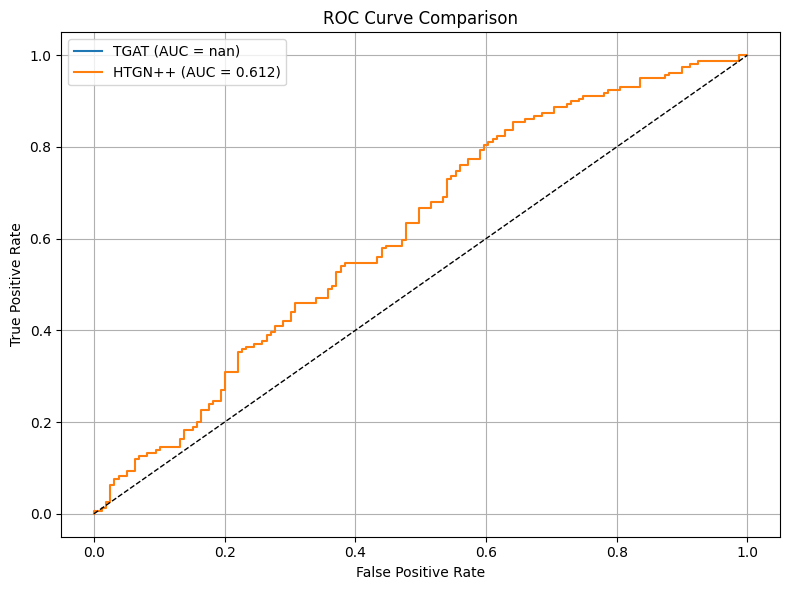

In [ ]:
plot_all_roc_curves("sample_twitter_data.csv", num_nodes=50)
